In [1]:
# This is only needed if the notebook is run in VSCode
import nbs_pipeline.utils.vscode  as vs
vs.DisplayHandle.update = vs.update_patch


# OR-ELM: Online Recurrent Extreme Learning Machine for time-series prediction

> This notebook applies visual analytics to [OR_ELM](https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine) algorithm

In [2]:
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!from tchub.all import *
import wandb
wandb_api = wandb.Api()
from fastcore.all import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from dvats.all import *
import nbs.orelm_torch as orelm

/home/macu/lib/orelm/
El directorio existe: /home/macu/lib/orelm/
['/home/macu/work/nbs_pipeline', '/home/macu/env/lib/python310.zip', '/home/macu/env/lib/python3.10', '/home/macu/env/lib/python3.10/lib-dynload', '', '/home/macu/env/lib/python3.10/site-packages', '/home/macu/env/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/macu/lib/tsai', '/home/macu/work']
['/home/macu/work/nbs_pipeline', '/home/macu/env/lib/python310.zip', '/home/macu/env/lib/python3.10', '/home/macu/env/lib/python3.10/lib-dynload', '', '/home/macu/env/lib/python3.10/site-packages', '/home/macu/env/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/home/macu/lib/tsai', '/home/macu/work', '/home/macu/lib/orelm/']


For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

## Notebook configuration

In [3]:
import nbs_pipeline.utils.config as cfg
config, job_type = cfg.get_artifact_config_ORELM(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/02c-encoder_orelm.yaml
... About to replace includes with content
Before configuration reading 
-include: None
-user_preferences:
	-use_wandb: False
	-wdb:
		-user: mi-santamaria
		-project_name: test-project
		-version: 0
		-mode: offline
		-artifacts_path: ./data/wandb_artifacts
	-data:
		-folder: ~/data/
		-fname: Semantic_Segmentation_TiltABP
		-ftype: .csv
		-cols: []
		-freq: 1s
	-artifact:
		-alias: TiltABP
	-directories:
		-tmp: tmp
		-data: ~/data/Semantic_Segmentation_TiltABP.csv
-data:
	-name: Semantic_Segmentation_TiltABP
	-path: ~/data/Semantic_Segmentation_TiltABP.csv
	-alias: TiltABP
	-cols: []
	-csv_config:
	-date_offset: None
	-date_format: %Y-%m-%d %H:%M:%S
	-freq: 1s
	-joining_train_test: False
	-missing_values:
		-technique: None
		-constant: None
	-normalize_training: False
	-range_training: None
	-range_testing: None
	-resampling_freq: None
	-start_date: None
	-test_split: None
	-time_col: None
-wandb:
	-user: mi

In [4]:
print("Project: "+config.wandb_project)
run = wandb.init(
    entity          = config.wandb_entity,
    project         = config.wandb_project,
    group           = config.wandb_group,
    job_type        = job_type,
    allow_val_change= True,
    mode            = 'online' if config.use_wandb else 'disabled',
    config          = config,
    resume          = False
)
config = run.config  # Object for storing hyperparameters
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

Project: test-project


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Loading the datasets

To load the dataset we will download a specific dataset artifact from the collection of artifacts
stored in the weights and biases (wandb) project associated to this experiment.

### Sliding window features

Define a continuous multivariate time-series data $D$ of dimension $d$ with $n$ time-steps, $D = X_1,X_2,\dots,X_n$ , where each $X_i = \{x_i^1,\dots,x_i^d\}$ . Let $w$ be the window width, $s$ the stride, and $t$ the start time of a sliding window in the data.

Define a new matrix $Z_k$ where each row is a vector of size $w$ of data extracted from the $k^{th}$ dimension.

\begin{aligned}&Z_k(w,s,t)\\&\quad =\begin{bmatrix} x_{t}^k&\quad x_{t+1}^k&\quad \dots&\quad x_{t+w-1}^k \\ x_{t+s}^k&\quad x_{t+s+1}^k&\quad \dots&\quad x_{t+s+w-1}^k \\ \vdots&\quad \vdots&\quad \ddots&\quad \vdots \\ x_{t+(r-1)s}^k&\quad x_{t+(r-1)s+1}^k&\quad \dots&\quad x_{t+(r-1)s+w-1}^k \end{bmatrix} \end{aligned}

where $r$ is the number of desired rows, and $t+(r-1)s+w-1 \le n$


$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

The hyperparameters of this sliding window approach are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [5]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

In [6]:
train_artifact = artifacts_gettr(config.train_artifact)
df_train = train_artifact.to_df()
X_train, _ = sw(df_train)
df_train.shape, X_train.shape

wandb:   1 of 1 files downloaded.  


((40000, 2), (39969, 2, 32))

In [7]:
if config.valid_artifact:
    valid_artifact = artifacts_gettr(config.valid_artifact)
    df_val = valid_artifact.to_df()
    X_valid, _ = sw(df_val)
    df_val.shape, X_valid.shape

## TODO: METER EXPLICACIÓN DE OR-ELM


todo: AQUI VA LA EXPLICACIÓN CON EL EJEMPLO QUE SE META EN EL PAPER

### Create the model

In [8]:
random.seed = config.random_seed

m = orelm.ORELM_torch(
    inputs                      = X_train.shape[1],
    outputs                     = 1,
    numHiddenNeurons            = config.numHiddenNeurons,
    activationFunction          = config.activationFunction,
    LN                          = config.LN,
    AE                          = config.AE,
    ORTH                        = config.ORTH,
    inputWeightForgettingFactor = config.inputWeightForgettingFactor,
    outputWeightForgettingFactor= config.outputWeightForgettingFactor
)
print(m)

(23, 2)
ORELM_torch()


Train the model with fastai Learner class, to abstract from Pytorch's training loop

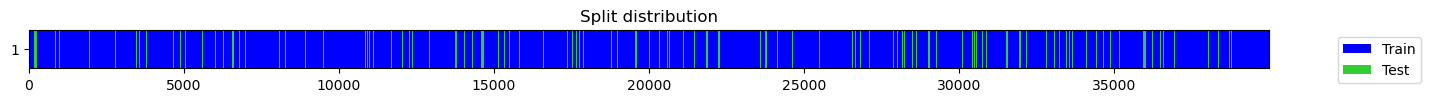

((#35973) [8168,19098,35538,37553,25691,33239,20038,904,17462,24019...],
 (#3996) [5429,14292,14145,35147,38290,21928,26339,13445,33763,5420...])

In [9]:
if config.valid_artifact:
    X, y, splits  = combine_split_data(xs=[X_train, X_valid], ys=[X_train, X_valid])
else:
    X = X_train
    y = X_train
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
splits

In [10]:
tfms = [ToFloat(), ToFloat()]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.dataset[0][0].show(), ToTSTensor()(dls.dataset[0][1]).show()




To track the performance of this model fit, go to the project dashboard in Weights & Biases. The link is provided at the beginning of this notebook, after the execution of the function `wandb.init()'' 

Finally, log the learner to be used by the next notebook in the pipeline

In [ ]:
print(dls.dataset)

(#35973) [(TSTensor(vars:2, len:32, device=cpu, dtype=torch.float32), tensor([[16412., 16413., 16414., 16415., 16416., 16417., 16418., 16419., 16420.,
         16421., 16422., 16423., 16424., 16425., 16426., 16427., 16428., 16429.,
         16430., 16431., 16432., 16433., 16434., 16435., 16436., 16437., 16438.,
         16439., 16440., 16441., 16442., 16443.],
        [ 4452.,  4440.,  4444.,  4424.,  4420.,  4416.,  4404.,  4396.,  4392.,
          4388.,  4380.,  4372.,  4380.,  4360.,  4364.,  4352.,  4360.,  4356.,
          4348.,  4336.,  4336.,  4340.,  4340.,  4328.,  4328.,  4320.,  4320.,
          4312.,  4328.,  4312.,  4320.,  4320.]])), (TSTensor(vars:2, len:32, device=cpu, dtype=torch.float32), tensor([[30076., 30077., 30078., 30079., 30080., 30081., 30082., 30083., 30084.,
         30085., 30086., 30087., 30088., 30089., 30090., 30091., 30092., 30093.,
         30094., 30095., 30096., 30097., 30098., 30099., 30100., 30101., 30102.,
         30103., 30104., 30105., 30106

# COPIANDO ORIGINAL ANTES DE TRADUCIR A WANDB (me he hecho un lío)

In [ ]:
dataSet = 'speed_6005'
filePath = '~/data/'+dataSet+'.csv'
print(filePath)
df = pd.read_csv(filePath, header=1, skiprows=[], names=['timestamp', 'data'])
df.head(5)
print(df['data'])

~/data/speed_6005.csv
0       80
1       84
2       94
3       90
4       91
        ..
2494    81
2495    89
2496    87
2497    82
2498    83
Name: data, Length: 2499, dtype: int64


In [ ]:
df.info()
print(df['data'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  2499 non-null   object
 1   data       2499 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.2+ KB
0       80
1       84
2       94
3       90
4       91
        ..
2494    81
2495    89
2496    87
2497    82
2498    83
Name: data, Length: 2499, dtype: int64


In [ ]:
df.isnull().sum()
print(df['data'])

0       80
1       84
2       94
3       90
4       91
        ..
2494    81
2495    89
2496    87
2497    82
2498    83
Name: data, Length: 2499, dtype: int64


In [ ]:
# standardize data by subtracting mean and dividing by std
print(df['data'])
meanSeq     = np.mean(df['data'])
print(meanSeq)
stdSeq      = np.std(df['data'])
print(stdSeq)
df['data'] = (df['data'] - meanSeq)/stdSeq
df.head()

0       80
1       84
2       94
3       90
4       91
        ..
2494    81
2495    89
2496    87
2497    82
2498    83
Name: data, Length: 2499, dtype: int64
81.90356142456983
8.7451068649251


,timestamp,data
0,2015-08-31 18:32:00,-0.217672
1,2015-08-31 18:57:00,0.239727
2,2015-08-31 19:07:00,1.383224
3,2015-08-31 19:12:00,0.925825
4,2015-08-31 19:17:00,1.040175


### Prepare input-target pairs

In [ ]:
def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1):
  print("generate time embedded matrix")
  inDim = numLags
  X = np.zeros(shape=(len(sequence), inDim))
  T = np.zeros(shape=(len(sequence), 1))
  for i in range(numLags-1, len(sequence)-predictionStep):
    X[i, :] = np.array(sequence['data'][(i-numLags+1):(i+1)])
    T[i, :] = sequence['data'][i+predictionStep]
  print('input shape: ',X.shape)
  print('target shape: ',T.shape)
  return (X, T)

(X, T) = getTimeEmbeddedMatrix(df, numLags = 10, predictionStep = 5)
print(X.shape, T.shape)

generate time embedded matrix
input shape:  (2499, 10)
target shape:  (2499, 1)
(2499, 10) (2499, 1)


In [ ]:
def linear_recurrent(features, inputW,hiddenW,hiddenA, bias):
  V = np.dot(features, np.transpose(inputW)) + np.dot(hiddenA,hiddenW) + bias
  return V

def layerNormalization(H, scaleFactor=1, biasFactor=0):

  H_normalized = (H-H.mean())/(np.sqrt(H.var() + 0.000001))
  H_normalized = scaleFactor*H_normalized+biasFactor

  return H_normalized

inputW = np.random.random((20,100))
print('input_weights:',inputW.shape)

hiddenW = np.random.random((20,20))
print('hidden_weights:',hiddenW.shape)

bias = np.random.random((1,20)) * 2 -1
print('bias:', bias.shape)

features = np.random.random((1,100))
print('input features:', features.shape)

hiddenA = np.random.random((1,20))

hidden = linear_recurrent(features,inputW,hiddenW,hiddenA,bias)
print('hidden:',hidden.shape)

hidden = layerNormalization(hidden)
print('hidden:',hidden.shape)


input_weights: (20, 100)
hidden_weights: (20, 20)
bias: (1, 20)
input features: (1, 100)
hidden: (1, 20)
hidden: (1, 20)


In [ ]:
m.initializePhase(lamb=0.0001)

 Unknown activation function type


NotImplementedError: 

In [ ]:
run.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▅▅▄▄▅▃▅▃▄▂▃▃▄▃▂▃▂▂▂▂▂▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▅▄▄▄▃▄▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_samples_per_sec,▇▇█▅▇██▇▇▇███▇▇▇▇▇████▇▇▇▇▇▇▅▇▆▇▇▇▁▇█▇██
valid_loss,█▆▅▅▄▄▄▄▃▃▃▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,200
